1.	Загрузить данные (Wine и Yoga из UCR).
	•	Первый столбец — метка класса, остальные — сам временной ряд.
2.	Привести ряды к общему виду через z-нормировку (каждый ряд отдельно).
	•	Чтобы убрать влияние масштаба и сравнивать именно форму сигналов.
3.	Провести небольшой EDA:
	•	распределение классов (bar chart);
	•	примеры рядов для каждого класса;
	•	среднее значение по классу и разброс.
4.	Сделать первую модель — 1-NN с евклидовой метрикой.
	•	Это базовый способ сравнивать ряды напрямую.
5.	Выделить признаки из рядов: статистики, моменты, автокорреляции, тренд.
	•	Преобразовать ряды в таблицу фичей.
6.	Обучить RandomForest на этих признаках.
	•	Подобрать гиперпараметры через кросс-валидацию на train.
7.	Сравнить результаты (accuracy, balanced accuracy, confusion matrix).
	•	Свести в таблицу и сохранить отчёт.

In [28]:
import os, json, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [7]:
base_dir = "/content"

# Список датасетов с путями
datasets = [
    ("Wine", os.path.join(base_dir, "Wine_TRAIN"), os.path.join(base_dir, "Wine_TEST")),
    ("Yoga", os.path.join(base_dir, "yoga_TRAIN"), os.path.join(base_dir, "yoga_TEST")),
]

In [8]:
# Формат UCR: в первой колонке — класс (целое), далее равной длины точки ряда (float).
data_cache = {}

for name, train_path, test_path in datasets:
    # Пытаемся загрузить через numpy (whitespace). Ну или через pandas с гибким sep
    try:
        arr_tr = np.loadtxt(train_path)
    except Exception:
        df_tr = pd.read_csv(train_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_tr = df_tr.values

    try:
        arr_te = np.loadtxt(test_path)
    except Exception:
        df_te = pd.read_csv(test_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_te = df_te.values

    if arr_tr.ndim == 1: arr_tr = arr_tr.reshape(1, -1)
    if arr_te.ndim == 1: arr_te = arr_te.reshape(1, -1)

    y_tr = arr_tr[:, 0].astype(int)
    X_tr = arr_tr[:, 1:].astype(float)

    y_te = arr_te[:, 0].astype(int)
    X_te = arr_te[:, 1:].astype(float)

    print(f"{name}: TRAIN shape = {X_tr.shape}, TEST shape = {X_te.shape}, classes(train) = {np.unique(y_tr)}")
    data_cache[name] = (X_tr, y_tr, X_te, y_te)


Wine: TRAIN shape = (57, 234), TEST shape = (54, 234), classes(train) = [1 2]
Yoga: TRAIN shape = (300, 426), TEST shape = (3000, 426), classes(train) = [1 2]


# **Нормализация**

In [9]:
data_cache_z = {}

for name in data_cache:
    X_tr, y_tr, X_te, y_te = data_cache[name]
    X_tr_z = np.empty_like(X_tr, dtype=float)
    X_te_z = np.empty_like(X_te, dtype=float)

    for i in range(X_tr.shape[0]):
        xi = X_tr[i]
        mu = xi.mean()
        sd = xi.std()
        if sd == 0.0:
            X_tr_z[i] = np.zeros_like(xi)
        else:
            X_tr_z[i] = (xi - mu) / sd

    for i in range(X_te.shape[0]):
        xi = X_te[i]
        mu = xi.mean()
        sd = xi.std()
        if sd == 0.0:
            X_te_z[i] = np.zeros_like(xi)
        else:
            X_te_z[i] = (xi - mu) / sd

    data_cache_z[name] = (X_tr_z, y_tr, X_te_z, y_te)
    print(f"{name}: Z-normalized — TRAIN mean≈{X_tr_z.mean():.3f}, std≈{X_tr_z.std():.3f}; TEST mean≈{X_te_z.mean():.3f}, std≈{X_te_z.std():.3f}")


Wine: Z-normalized — TRAIN mean≈-0.000, std≈1.000; TEST mean≈0.000, std≈1.000
Yoga: Z-normalized — TRAIN mean≈0.000, std≈1.000; TEST mean≈-0.000, std≈1.000


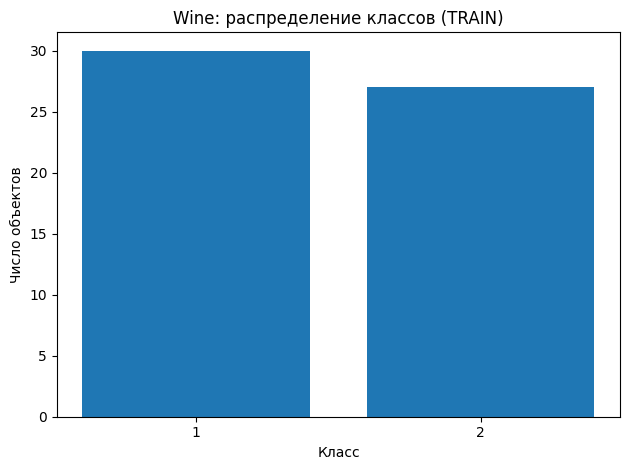

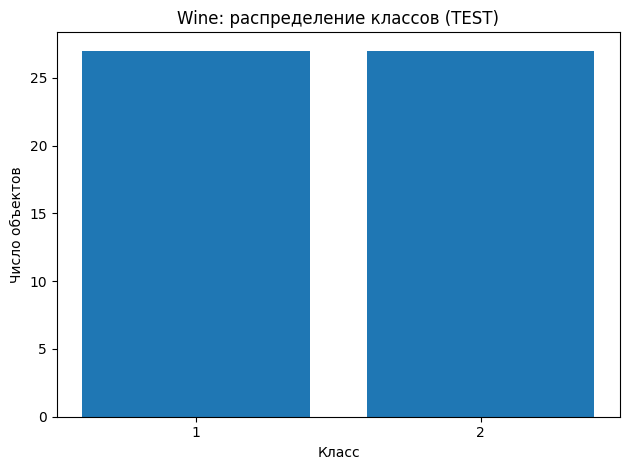

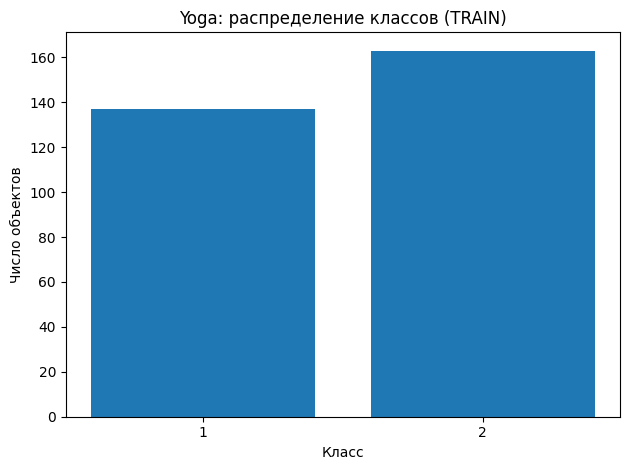

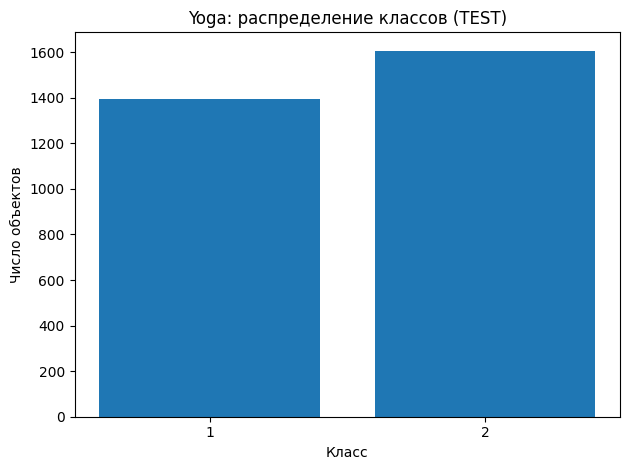

In [15]:
# Строим bar chart по классам на TRAIN/TEST
for name in data_cache:
    X_tr, y_tr, X_te, y_te = data_cache[name]

    classes_tr, counts_tr = np.unique(y_tr, return_counts=True)
    plt.figure()
    plt.bar(classes_tr.astype(str), counts_tr)
    plt.title(f"{name}: распределение классов (TRAIN)")
    plt.xlabel("Класс"); plt.ylabel("Число объектов")
    plt.tight_layout()
    plt.show()

    classes_te, counts_te = np.unique(y_te, return_counts=True)
    plt.figure()
    plt.bar(classes_te.astype(str), counts_te)
    plt.title(f"{name}: распределение классов (TEST)")
    plt.xlabel("Класс"); plt.ylabel("Число объектов")
    plt.tight_layout()
    plt.show()

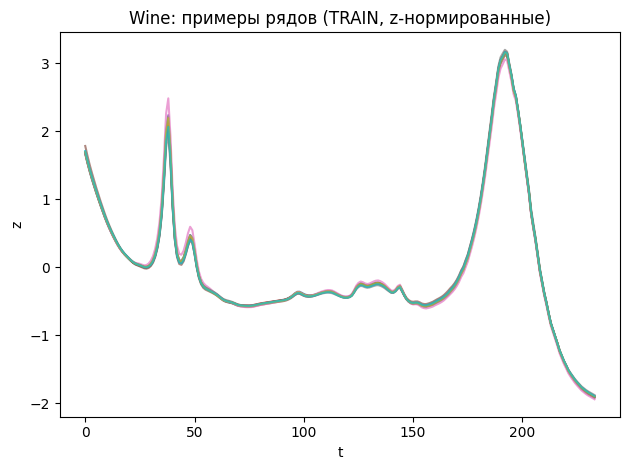

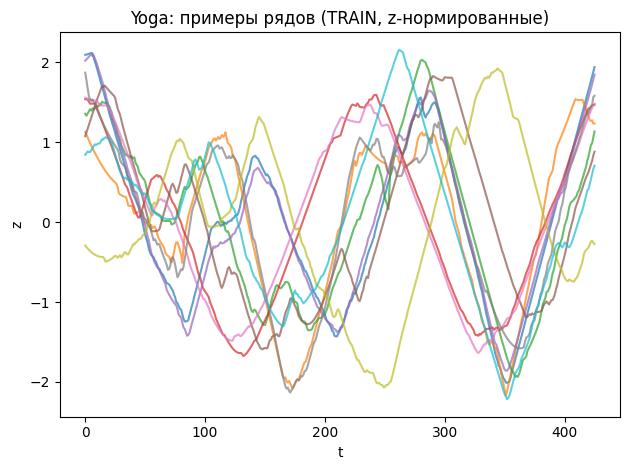

In [19]:
rs = np.random.RandomState(42)

# Для каждого класса выводим до 5 случайных рядов поверх друг друга, чтобы увидеть вариативность формы.
for name in data_cache_z:
    X_tr_z, y_tr, X_te_z, y_te = data_cache_z[name]
    classes = np.unique(y_tr)

    plt.figure()
    for c in classes:
        idx = np.where(y_tr == c)[0]
        if len(idx) > 5:
            idx = rs.choice(idx, size=5, replace=False)
        for i in idx:
            plt.plot(X_tr_z[i], alpha=0.7)
    plt.title(f"{name}: примеры рядов (TRAIN, z-нормированные)")
    plt.xlabel("t"); plt.ylabel("z")
    plt.tight_layout()
    plt.show()

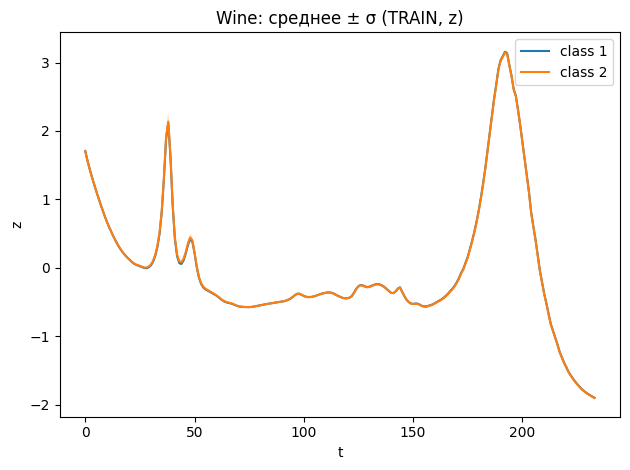

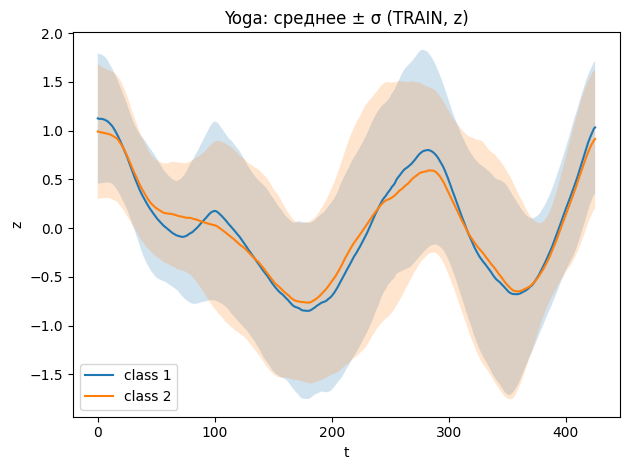

In [20]:
# Для каждого класса считаем средний ряд и стандартное отклонение, лента (mean ± std).
for name in data_cache_z:
    X_tr_z, y_tr, X_te_z, y_te = data_cache_z[name]
    classes = np.unique(y_tr)
    t = np.arange(X_tr_z.shape[1])

    plt.figure()
    for c in classes:
        Xi = X_tr_z[y_tr == c]
        mu = Xi.mean(axis=0)
        sd = Xi.std(axis=0)
        plt.plot(t, mu, linewidth=1.5, label=f"class {c}")
        plt.fill_between(t, mu - sd, mu + sd, alpha=0.2)
    plt.legend()
    plt.title(f"{name}: среднее ± σ (TRAIN, z)")
    plt.xlabel("t"); plt.ylabel("z")
    plt.tight_layout()
    plt.show()

In [22]:
# Для итогов
all_results_rows = []
all_cm = {}


# Обучаем 1-NN (k=1, евклид) на TRAIN(z) и предсказываем на TEST(z).
for name in data_cache_z:
    X_tr_z, y_tr, X_te_z, y_te = data_cache_z[name]

    t0 = time.time()
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean', algorithm='brute', n_jobs=-1)
    knn.fit(X_tr_z, y_tr)
    y_pred = knn.predict(X_te_z)
    t1 = time.time()

    acc = accuracy_score(y_te, y_pred)
    bal_acc = balanced_accuracy_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(f"[{name}] 1-NN Euclidean (z): acc={{acc:.4f}}, bal_acc={{bal_acc:.4f}}, time={{t1-t0:.2f}}s")
    display(pd.DataFrame(cm))

    # Сохраняем
    all_results_rows.append({
        "dataset": name, "model": "1-NN Euclidean (z)", "accuracy": round(acc, 4),
        "balanced_accuracy": round(bal_acc, 4), "inference_sec": round(t1 - t0, 2)
    })
    all_cm[(name, "1-NN Euclidean (z)")] = cm.tolist()

[Wine] 1-NN Euclidean (z): acc={acc:.4f}, bal_acc={bal_acc:.4f}, time={t1-t0:.2f}s


,0,1
0,16,11
1,10,17


[Yoga] 1-NN Euclidean (z): acc={acc:.4f}, bal_acc={bal_acc:.4f}, time={t1-t0:.2f}s


,0,1
0,1098,295
1,214,1393


In [24]:
# Соберём компактный набор фич для каждого ряда:
# mean, std, min, max, median, skew, kurt, energy, zero_cross,
# slope (линейный тренд), ACF на лагах 1..5.
Xtr_feats = {}
Xte_feats = {}
for name in data_cache_z:
    X_tr_z, y_tr, X_te_z, y_te = data_cache_z[name]

    # TRAIN -> фичи
    feats_list_tr = []
    for xi in X_tr_z:
        n = len(xi)
        mu = xi.mean()
        sd = xi.std()
        # z для моментов
        if sd == 0:
            z = np.zeros_like(xi)
        else:
            z = (xi - mu) / (sd + 1e-12)
        # базовые
        mn = float(xi.min())
        mx = float(xi.max())
        med = float(np.median(xi))
        skew = float(np.mean(z**3))
        kurt = float(np.mean(z**4) - 3.0)
        energy = float(np.mean(xi**2))
        zc = int(np.sum(np.signbit(xi)[:-1] != np.signbit(xi)[1:]))
        # slope
        t = np.arange(n)
        slope = float(np.polyfit(t, xi, 1)[0]) if n > 1 else 0.0
        # ACF 1..5
        x0 = xi - mu
        var = float((x0**2).sum())
        if var == 0:
            acf = np.zeros(5)
        else:
            corr = np.correlate(x0, x0, mode="full")
            mid = len(corr)//2
            a = corr[mid:mid+6] / var
            acf = a[1:6]
        feats_list_tr.append({
            "mean": mu, "std": sd, "min": mn, "max": mx, "median": med,
            "skew": skew, "kurt": kurt, "energy": energy, "zero_cross": zc,
            "slope": slope, "acf_1": float(acf[0]), "acf_2": float(acf[1]), "acf_3": float(acf[2]), "acf_4": float(acf[3]), "acf_5": float(acf[4])
        })
    Xtr_feats[name] = pd.DataFrame(feats_list_tr)

    # TEST -> фичи (аналогично)
    feats_list_te = []
    for xi in X_te_z:
        n = len(xi)
        mu = xi.mean()
        sd = xi.std()
        if sd == 0:
            z = np.zeros_like(xi)
        else:
            z = (xi - mu) / (sd + 1e-12)
        mn = float(xi.min()); mx = float(xi.max()); med = float(np.median(xi))
        skew = float(np.mean(z**3)); kurt = float(np.mean(z**4) - 3.0)
        energy = float(np.mean(xi**2))
        zc = int(np.sum(np.signbit(xi)[:-1] != np.signbit(xi)[1:]))
        t = np.arange(n); slope = float(np.polyfit(t, xi, 1)[0]) if n > 1 else 0.0
        x0 = xi - mu; var = float((x0**2).sum())
        if var == 0:
            acf = np.zeros(5)
        else:
            corr = np.correlate(x0, x0, mode="full")
            mid = len(corr)//2
            a = corr[mid:mid+6] / var
            acf = a[1:6]
        feats_list_te.append({
            "mean": mu, "std": sd, "min": mn, "max": mx, "median": med,
            "skew": skew, "kurt": kurt, "energy": energy, "zero_cross": zc,
            "slope": slope, "acf_1": float(acf[0]), "acf_2": float(acf[1]), "acf_3": float(acf[2]), "acf_4": float(acf[3]), "acf_5": float(acf[4])
        })
    Xte_feats[name] = pd.DataFrame(feats_list_te)

    print(f"{name} — фичей: {Xtr_feats[name].shape[1]}; TRAIN: {Xtr_feats[name].shape}, TEST: {Xte_feats[name].shape}")
    display(Xtr_feats[name].head(3))

Wine — фичей: 15; TRAIN: (57, 15), TEST: (54, 15)


,mean,std,min,max,median,skew,kurt,energy,zero_cross,slope,acf_1,acf_2,acf_3,acf_4,acf_5
0,1.138690e-17,1.0,-1.923014,3.126290,-0.342242,1.160558,1.640021,1.0,5,-0.001652,0.977450,0.942689,0.900128,0.853551,0.805004
1,1.897817e-18,1.0,-1.923412,3.111953,-0.333693,1.150415,1.603278,1.0,5,-0.001643,0.977327,0.942255,0.899342,0.852514,0.803883
2,1.328472e-17,1.0,-1.926721,3.106443,-0.331099,1.143505,1.588682,1.0,5,-0.001671,0.977258,0.942019,0.898917,0.851926,0.803173


Yoga — фичей: 15; TRAIN: (300, 15), TEST: (3000, 15)


,mean,std,min,max,median,skew,kurt,energy,zero_cross,slope,acf_1,acf_2,acf_3,acf_4,acf_5
0,3.335881e-17,1.0,-2.147514,1.817730,-0.061847,-0.183745,-0.596899,1.0,6,0.001379,0.998973,0.996191,0.991801,0.985900,0.978570
1,6.671763e-17,1.0,-2.173054,1.930468,-0.110055,-0.100188,-0.592161,1.0,6,0.000423,0.996713,0.991513,0.984419,0.975734,0.965292
2,-1.667941e-17,1.0,-2.068631,1.535303,0.117642,-0.464057,-0.823073,1.0,10,0.000620,0.996613,0.991392,0.984429,0.975749,0.965462


In [26]:
# Обучаем RF на построенных фичах. Подберём простую решётку по max_depth, n_estimators на 3-фолд CV.
for name in data_cache_z:
    X_tr_z, y_tr, X_te_z, y_te = data_cache_z[name]
    Xtr_f = Xtr_feats[name]
    Xte_f = Xte_feats[name]

    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grid = {"n_estimators": [200], "max_depth": [None, 20]}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    gscv = GridSearchCV(rf, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=0)
    gscv.fit(Xtr_f, y_tr)

    best = gscv.best_estimator_
    y_pred = best.predict(Xte_f)

    acc = accuracy_score(y_te, y_pred)
    bal_acc = balanced_accuracy_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(f"[{name}] RF(features): acc={acc:.4f}, bal_acc={bal_acc:.4f}, best_params={gscv.best_params_}")
    display(pd.DataFrame(cm))

    all_results_rows.append({
        "dataset": name, "model": "RF(features)", "accuracy": round(acc, 4),
        "balanced_accuracy": round(bal_acc, 4), "inference_sec": np.nan
    })
    all_cm[(name, "RF(features)")] = cm.tolist()

[Wine] RF(features): acc=0.5370, bal_acc=0.5370, best_params={'max_depth': None, 'n_estimators': 200}


,0,1
0,14,13
1,12,15


[Yoga] RF(features): acc=0.7723, bal_acc=0.7696, best_params={'max_depth': None, 'n_estimators': 200}


,0,1
0,1019,374
1,309,1298


In [27]:
# Сводная таблица
summary_df = pd.DataFrame(all_results_rows).sort_values(["dataset", "accuracy"], ascending=[True, False]).reset_index(drop=True)
display(summary_df)

,dataset,model,accuracy,balanced_accuracy,inference_sec
0,Wine,1-NN Euclidean (z),0.6111,0.6111,0.01
1,Wine,RF(features),0.5370,0.5370,NaN
2,Wine,RF(features),0.5370,0.5370,NaN
3,Yoga,1-NN Euclidean (z),0.8303,0.8275,0.04
4,Yoga,RF(features),0.7723,0.7696,NaN
5,Yoga,RF(features),0.7723,0.7696,NaN
